In [2]:
using Plots
using LinearAlgebra
using FFTW
using Dates

# Гармонические колебания
function harmonic_chain_simulation(;
    N=20,          # Количество частиц
    m=1.0,         # Масса частицы
    k=1.0,         # Жёсткость пружины
    α=0.0,         # Коэффициент ангармоничности (0 для гармонического случая)
    T=100.0,       # Общее время моделирования
    Δt=0.01,       # Шаг по времени
    Δd=1.0,        # Расстояние между частицами
    initial_displacement=0.1,  # Амплитуда начального возмущения
    save_every=10  # Сохранять состояние каждые save_every шагов
)
    # Инициализация массивов (включая граничные условия)
    y = zeros(N+2)  # Смещения (y[1] и y[N+2] - граничные условия)
    v = zeros(N+2)  # Скорости
    a = zeros(N+2)  # Ускорения
    
    # Начальные условия - синусоидальное возмущение
    for i in 2:N+1
        y[i] = initial_displacement * sin(π*(i-1)/N)
    end
    
    # Массивы для сохранения результатов
    times = Float64[]
    positions = Vector{Float64}[]
    velocities = Vector{Float64}[]
    
    # Основной цикл моделирования
    for t in 0:Δt:T
        # Вычисление ускорений для внутренних частиц
        for i in 2:N+1
            Δy_prev = y[i] - y[i-1]
            Δy_next = y[i+1] - y[i]
            
            # Гармоническая часть силы
            F_harmonic = k * (y[i+1] - 2*y[i] + y[i-1])
            
            # Ангармоническая часть силы (если α ≠ 0)
            F_anharmonic = α * (Δy_next^3 + Δy_prev^3)
            
            a[i] = (F_harmonic + F_anharmonic) / m
        end
        
        # Обновление скоростей и смещений (метод Верле)
        for i in 2:N+1
            v[i] += a[i] * Δt
            y[i] += v[i] * Δt
        end
        
        # Применение граничных условий
        y[1] = 0.0
        y[N+2] = 0.0
        
        # Сохранение состояния (не на каждом шаге для экономии памяти)
        if mod(round(t/Δt), save_every) == 0
            push!(times, t)
            push!(positions, copy(y[2:N+1]))  # Исключаем граничные точки
            push!(velocities, copy(v[2:N+1]))
        end
    end
    
    return times, positions, velocities
end

# Функция для визуализации результатов
function plot_chain_dynamics(times, positions, velocities; title="")
    # Генерируем уникальное имя файла на основе текущего времени
    timestamp = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
    filename = "chain_dynamics_$(timestamp).gif"
    
    # Анимация колебаний
    anim = @animate for (i, t) in enumerate(times)
        p1 = plot(positions[i], 
                 xlabel="Номер частицы", ylabel="Смещение",
                 title="$title, t = $(round(t, digits=2))",
                 ylims=(-maximum(abs.(positions[1]))*1.1, maximum(abs.(positions[1]))*1.1),
                 legend=false)
        scatter!(p1, positions[i], color=:red)
        
        p2 = plot(velocities[i],
                 xlabel="Номер частицы", ylabel="Скорость",
                 ylims=(-maximum(abs.(velocities[1]))*1.1, maximum(abs.(velocities[1]))*1.1),
                 legend=false)
        scatter!(p2, velocities[i], color=:blue)
        
        plot(p1, p2, layout=(2,1))
    end
    
    # Сохраняем анимацию в файл с уникальным именем
    gif(anim, filename, fps=15)
    println("Анимация сохранена в файл: ", filename)
end

# Функция для анализа спектра
function analyze_spectrum(positions, Δt)
    # Анализ спектра для центральной частицы
    central_particle = [pos[length(pos)÷2] for pos in positions]
    n = length(central_particle)
    
    # Вычисление БПФ
    fft_result = fft(central_particle)
    freqs = fftfreq(n, 1/Δt)
    power = abs.(fft_result).^2
    
    # Только положительные частоты
    idx = freqs .> 0
    freqs = freqs[idx]
    power = power[idx]
    
    plot(freqs, power, xlabel="Частота", ylabel="Мощность", 
         title="Спектр колебаний центральной частицы", legend=false)
end

# Пример использования для гармонической цепочки
times_harmonic, positions_harmonic, velocities_harmonic = harmonic_chain_simulation(
    N=30, T=50.0, Δt=0.05, initial_displacement=0.2, α=0.0
)


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed FFTW ───────── v1.8.1
   Installed AbstractFFTs ─ v1.5.0
   Installed FFTW_jll ───── v3.3.11+0
    Updating `~/.julia/environments/v1.11/Project.toml`
  [7a1cc6ca] + FFTW v1.8.1
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [621f4979] + AbstractFFTs v1.5.0
  [7a1cc6ca] + FFTW v1.8.1
  [f5851436] + FFTW_jll v3.3.11+0
Precompiling project...
   1504.2 ms  ✓ AbstractFFTs
   1335.0 ms  ✓ FFTW_jll
    697.2 ms  ✓ AbstractFFTs → AbstractFFTsChainRulesCoreExt
   1554.0 ms  ✓ AbstractFFTs → AbstractFFTsTestExt
   8408.8 ms  ✓ FFTW
  5 dependencies successfully precompiled in 12 seconds. 461 already precompiled.


([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  45.5, 46.0, 46.5, 47.0, 47.5, 48.0, 48.5, 49.0, 49.5, 50.0], [[0.020905120035671916, 0.041581199201555404, 0.061801706047561314, 0.08134510046927171, 0.09999726094768413, 0.11755383050938158, 0.13382245570429774, 0.14862489407036833, 0.16179896699524549, 0.17320033657911207  …  0.16179896699524549, 0.1486248940703684, 0.13382245570429777, 0.1175538305093816, 0.09999726094768413, 0.0813451004692717, 0.06180170604756134, 0.041581199201555404, 0.02090512003567189, 5.22642316339394e-5], [0.02086791108783805, 0.041507188974906614, 0.061691705413628395, 0.08120031461801915, 0.09981927618319661, 0.11734459686998458, 0.13358426559752942, 0.1483603571568829, 0.16151098159682506, 0.1728920579240466  …  0.16151098159682506, 0.14836035715688298, 0.13358426559752945, 0.11734459686998465, 0.09981927618322775, 0.0812003146340544, 0.061691710539047526, 0.04150813876062853, 0.020957471936317536, 0.0032664242149885807], [0.020773556754844665, 0.0413

[ Info: Saved animation to /home/sc24/rudn/mathmod/mathmod/project-group/stage3/chain_dynamics_2025-05-02_08-14-40.gif


Анимация сохранена в файл: chain_dynamics_2025-05-02_08-14-40.gif
Анимация сохранена в файл: chain_dynamics_2025-05-02_08-14-47.gif


[ Info: Saved animation to /home/sc24/rudn/mathmod/mathmod/project-group/stage3/chain_dynamics_2025-05-02_08-14-47.gif


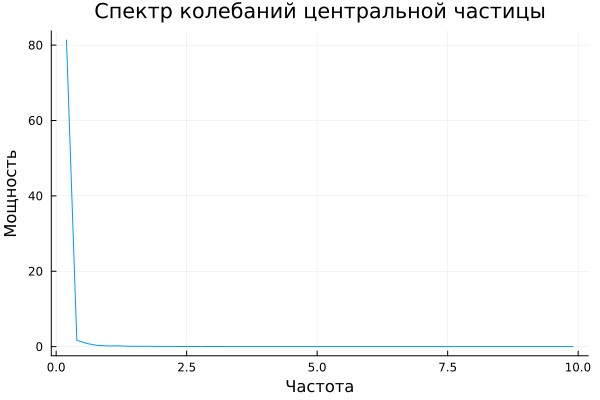

In [4]:
#Визуализация
plot_chain_dynamics(times_harmonic, positions_harmonic, velocities_harmonic, title="Гармонические колебания")
analyze_spectrum(positions_harmonic, 0.05)

# Пример использования для ангармонической цепочки
times_anharmonic, positions_anharmonic, velocities_anharmonic = harmonic_chain_simulation(
    N=30, T=50.0, Δt=0.05, initial_displacement=0.2, α=0.1
)

# Визуализация
plot_chain_dynamics(times_anharmonic, positions_anharmonic, velocities_anharmonic, title="Ангармонические колебания")
analyze_spectrum(positions_anharmonic, 0.05)


Анимация сохранена в файл: chain_dynamics_2025-05-02_09-23-04.gif


[ Info: Saved animation to /home/sc24/rudn/mathmod/mathmod/project-group/stage3/chain_dynamics_2025-05-02_09-23-04.gif


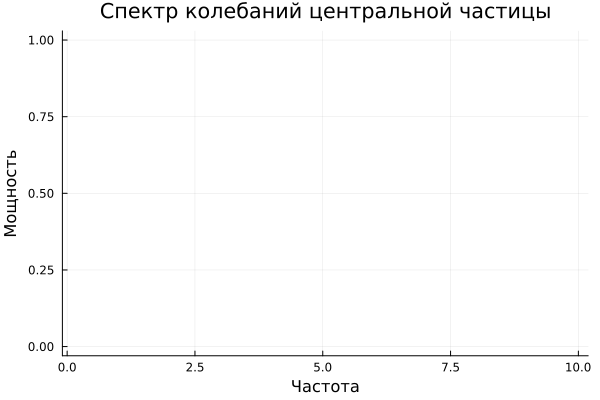

In [8]:
# Ангармоническая модель: используем α ≠ 0
times_anharmonic, positions_anharmonic, velocities_anharmonic = harmonic_chain_simulation(
    N=30,              # Частиц
    T=50.0,            # Время моделирования
    Δt=0.05,           # Шаг по времени
    initial_displacement=0.2,
    α=50              # Коэффициент ангармонии — можно поэкспериментировать
)

# Визуализация колебаний
plot_chain_dynamics(times_anharmonic, positions_anharmonic, velocities_anharmonic,
    title="Ангармонические колебания")

# Спектральный анализ — будет видна энергия в обертонах
analyze_spectrum(positions_anharmonic, 0.05)
